# Установка библиотек

In [1]:
!pip install pandas
!pip install matplotlib
!pip install -U scikit-learn

In [2]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import psycopg2 

### загружаю сессии 

загружаю данные через PostgreSQL

In [3]:
conn = psycopg2.connect(
    dbname="data",#то что под databases
    user="postgres",
    password="486252522",
    host="localhost",
    port="5433"
)
cursor = conn.cursor()
cursor.execute("SELECT * FROM public.expenses")
results = cursor.fetchall()

expenses1 = pd.DataFrame(results)

cursor = conn.cursor()
cursor.execute("SELECT * FROM public.orders")
results = cursor.fetchall()

orders = pd.DataFrame(results)

cursor = conn.cursor()
cursor.execute("SELECT * FROM public.visitation")
results = cursor.fetchall()

visitation = pd.DataFrame(results)

cursor = conn.cursor()
cursor.execute("SELECT * FROM public.merged_data")
results = cursor.fetchall()

merged_data1 = pd.DataFrame(results)
conn.close()

придаю название колоннам , так как они загрузились без названия 

In [4]:
expenses1.columns=['dt',	'Channel'	,'costs']
orders.columns=['User Id', 'Event Dt', 'Revenue']
merged_data1.columns = ['dt'	, 'Channel'	,'costs'	,'User Id'	,'Event Dt',	'Revenue','User Id1',	'Region',	'Device', 'Channel1'		,'Session Start',	'Session End']

дропаю не нужные колонны

In [5]:
merged_data1.drop(['User Id1', 'Channel1'], axis= 1 , inplace= True )

In [6]:
merged_data=merged_data1.fillna('No Info')#заполняю пустые значения в таблице 
merged_data1.head()

,dt,Channel,costs,User Id,Event Dt,Revenue,Region,Device,Session Start,Session End
0,2022-05-01,FaceBoom,113.3,188246423999.0,2022-05-01 23:09:52,4.99,Russia,iPhone,2022-05-01 02:36:01,2022-05-01 02:45:01
1,2022-05-02,FaceBoom,78.10000000000001,174361394180.0,2022-05-01 12:24:04,4.99,Russia,iPhone,2022-05-01 04:46:31,2022-05-01 04:47:35
2,2022-05-03,FaceBoom,85.80000000000001,529610067795.0,2022-05-01 11:34:04,4.99,Russia,Mac,2022-05-01 14:09:25,2022-05-01 15:32:08
3,2022-05-04,FaceBoom,136.4,319939546352.0,2022-05-01 15:34:40,4.99,Russia,Android,2022-05-01 00:29:59,2022-05-01 00:54:25
4,2022-05-05,FaceBoom,122.1,366000285810.0,2022-05-01 13:59:51,4.99,Russia,Mac,2022-05-01 03:33:35,2022-05-01 03:57:40


In [473]:
merged_data1.to_csv("data.csv", index=False)

## я перекодирую данные два раза для того чтобы одну использовать для сегментации , а другую для обучения 

In [7]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

merged_data2, encoders = number_encode_features(merged_data1) # Теперь encoded data содержит закодированные кат. признаки
merged_data2.head()

,dt,Channel,costs,User Id,Event Dt,Revenue,Region,Device,Session Start,Session End
0,0,1,54,845,24,1,1,3,99,85
1,1,1,556,701,13,1,1,3,169,159
2,2,1,581,4286,12,1,1,1,508,546
3,3,1,99,2186,17,1,1,0,27,24
4,4,1,74,2627,15,1,1,1,128,130


In [8]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

merged_data, encoders = number_encode_features(merged_data1) # Теперь encoded data содержит закодированные кат. признаки
merged_data.head()

,dt,Channel,costs,User Id,Event Dt,Revenue,Region,Device,Session Start,Session End
0,0,1,54,845,24,1,1,3,99,85
1,1,1,556,701,13,1,1,3,169,159
2,2,1,581,4286,12,1,1,1,508,546
3,3,1,99,2186,17,1,1,0,27,24
4,4,1,74,2627,15,1,1,1,128,130


# 3.1 Сегментация пользователей

привожу данные к нужному формату 

In [9]:
import pandas as pd

# Загрузка данных из CSV файла
data = merged_data2

# Преобразование столбцов с датами в формат datetime
data['dt'] = pd.to_datetime(data['dt'])
data['Event Dt'] = pd.to_datetime(data['Event Dt'])
data['Session Start'] = pd.to_datetime(data['Session Start'])
data['Session End'] = pd.to_datetime(data['Session End'])

# Проверяем типы данных столбцов
print(data.dtypes)


dt               datetime64[ns]
Channel                   int32
costs                     int32
User Id                   int32
Event Dt         datetime64[ns]
Revenue                   int32
Region                    int32
Device                    int32
Session Start    datetime64[ns]
Session End      datetime64[ns]
dtype: object


сегментация 

In [14]:
#3.1 Сегментация пользователей
merged_data2['Event Dt'] = pd.to_datetime(merged_data2['Event Dt']) 
merged_data2['dt'] = pd.to_datetime(merged_data2['dt']) 
 
#Recency, Frequency, Monetary 
max_date = merged_data2['Event Dt'].max() 
rfm = merged_data2.groupby('User Id').agg({ 
    'Event Dt': lambda x: (max_date - x.max()).days,  # Recency 
    'dt': 'count',  # Frequency 
    'Revenue': 'sum'  # Monetary 
}).reset_index() 
 
rfm.columns = ['User Id', 'Recency', 'Frequency', 'Monetary'] 
 
# Сегментация пользователей
# Создание квантилей для каждого параметра RFM
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75]) 
quantiles = quantiles.to_dict() 
 
# Функция назначения сегментов
def rfm_segment(row): 
    recency = row['Recency'] 
    if recency <= quantiles['Recency'][0.25]: 
        return '1'  #лучший 
    elif recency <= quantiles['Recency'][0.5]: 
        return '2'  #хороший 
    elif recency <= quantiles['Recency'][0.75]: 
        return '3'  #не очень хороший
    else: 
        return '4'  #худший
 
#Применяем функцию к каждой строке
rfm['RFM Segment'] = rfm.apply(rfm_segment, axis=1) 
 
rfm.head() #таблица с сегментация пользователей

,User Id,Recency,Frequency,Monetary,RFM Segment
0,0,0,1,1,1
1,1,0,4,4,1
2,2,0,10,10,1
3,3,0,8,10,1
4,4,0,6,9,1


In [443]:
import pandas as pd

# Загрузка данных из CSV файла
data = merged_data2

# Предполагается, что столбцы 'Event Dt', 'User Id' и 'Revenue' присутствуют в данных

# Проведение RFM анализа
snapshot_date = pd.to_datetime(data['Event Dt']).max() + pd.Timedelta(days=1)
rfm_table = data.groupby('User Id').agg({
    'Event Dt': lambda x: (snapshot_date - pd.to_datetime(x.max())).days,  # Recency
    'User Id': 'count',                                                   # Frequency
    'Revenue': 'sum'                                                       # Monetary
})

# Переименование столбцов
rfm_table.rename(columns={'Event Dt': 'Recency',
                          'User Id': 'Frequency',
                          'Revenue': 'Monetary'}, inplace=True)

# Сегментация пользователей
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, parameter, quantiles):
    if x <= quantiles[parameter][0.25]:
        return 1
    elif x <= quantiles[parameter][0.50]:
        return 2
    elif x <= quantiles[parameter][0.75]:
        return 3
    else:
        return 4

rfm_table['R'] = rfm_table['Recency'].apply(rfm_score, args=('Recency', quantiles))
rfm_table['F'] = rfm_table['Frequency'].apply(rfm_score, args=('Frequency', quantiles))
rfm_table['M'] = rfm_table['Monetary'].apply(rfm_score, args=('Monetary', quantiles))

# Объединение R, F и M для получения RFM сегмента
rfm_table['RFM_Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str) + rfm_table['M'].astype(str)

## Исследование уровней удержания пользователей различных групп

In [444]:
retention_rates = data.groupby('User Id')['Event Dt'].min().value_counts().sort_index() / data['User Id'].nunique()

In [445]:
retention_rates

Event Dt
1970-01-01 00:00:00.000000000    0.000113
1970-01-01 00:00:00.000000001    0.000113
1970-01-01 00:00:00.000000002    0.000113
1970-01-01 00:00:00.000000003    0.000113
1970-01-01 00:00:00.000000004    0.000113
                                   ...   
1970-01-01 00:00:00.000040084    0.000113
1970-01-01 00:00:00.000040089    0.000113
1970-01-01 00:00:00.000040141    0.000113
1970-01-01 00:00:00.000040152    0.000113
1970-01-01 00:00:00.000040163    0.000113
Name: count, Length: 8877, dtype: float64

## Исследование количества совершенных покупок пользователей различных групп

In [446]:
avg_purchase_count = data.groupby('User Id')['Event Dt'].count().mean()

In [447]:
avg_purchase_count

34.89090294978608

## Исследование времени между совершениями покупок пользователей различных групп

In [448]:
purchase_intervals = data.groupby('User Id')['Event Dt'].apply(lambda x: x.diff().mean())

In [449]:
purchase_intervals

User Id
0                            NaT
1      0 days 00:00:00.000001139
2      0 days 00:00:00.000003177
3      0 days 00:00:00.000002300
4      0 days 00:00:00.000004897
                  ...           
8877   0 days 00:00:00.000005168
8878                         NaT
8879   0 days 00:00:00.000001259
8880                         NaT
8881             0 days 00:00:00
Name: Event Dt, Length: 8882, dtype: timedelta64[ns]

## Рекомендация для оптимизации модели 

1  Оптимизация базы данных: Оптимизируйте запросы к базе данных, используя индексы, предварительное вычисление и кэширование данных, а также разбивку на несколько таблиц для избежания избыточности.

2 
Улучшение алгоритмов и структур данных: Пересмотрите алгоритмы и структуры данных, используемые в вашем приложении. Иногда замена неэффективных алгоритмов или структур данных может значительно улучшить производительность.

## Итог

в результате сегментации , я получил что :


Исследование уровней удержания пользователей различных групп равно  примерно  0.000113


Исследование количества совершенных покупок пользователей различных групп равно примерно 35



Исследование времени между совершениями покупок пользователей различных групп равно 











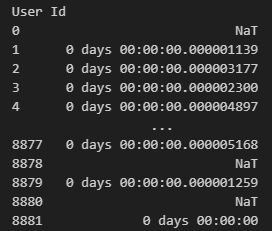

# 3.2 Построение регрессионной модели

In [450]:
X=merged_data
X.head()

,dt,Channel,costs,User Id,Event Dt,Revenue,Region,Device,Session Start,Session End
0,0,1,54,845,24,1,1,3,99,85
1,1,1,556,701,13,1,1,3,169,159
2,2,1,581,4286,12,1,1,1,508,546
3,3,1,99,2186,17,1,1,0,27,24
4,4,1,74,2627,15,1,1,1,128,130


In [451]:
y=merged_data['Channel']

разделяем данные на обучающую и тестовую выборки

test_size=0.2 задает размер тестовой выборки в 20% от исходных данных.

random_state=42 задает начальное значение для генератора случайных чисел, чтобы результаты можно было воспроизвести.

In [452]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## random forest

Random Forest (Случайный лес): Эта модель хорошо обрабатывает разнообразные типы данных, автоматически обрабатывает пропущенные значения, устойчива к переобучению и не требует масштабирования признаков. Также, она способна работать с большим количеством признаков, что может быть важным при анализе данных о дорожных ситуациях.

In [453]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [454]:
y_pred = model.predict(X_test)

Оценка R2 – очень важный показатель, который используется для оценки производительности модели машинного обучения на основе регрессии.

In [455]:
r2_score(model.predict(X_test), y_test)

1.0

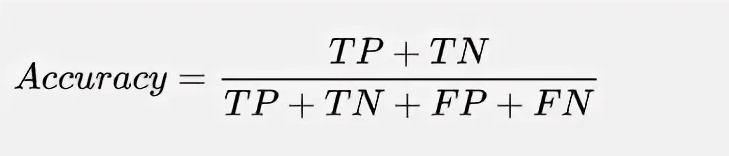

Accuracy — это метрика, которая описывает общую точность предсказания модели по всем классам.

In [456]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 1.0


## SVM

 SVM хорошо работает для задач классификации, особенно в случае, когда данные не очень объемные, и есть ярко выраженные разделители между классами. SVM также позволяет легко справляться с нелинейными зависимостями с помощью ядерных функций.

разделяем данные на обучающую и тестовую выборки

test_size=0.2 задает размер тестовой выборки в 20% от исходных данных.

random_state=42 задает начальное значение для генератора случайных чисел, чтобы результаты можно было воспроизвести.

In [457]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [458]:
model = make_pipeline(StandardScaler(), SVC())

In [459]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [460]:
y_pred = model.predict(X_test)

Accuracy — это метрика, которая описывает общую точность предсказания модели по всем классам.

In [461]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.9999515980703764


## KNN

Метод k-ближайших соседей (KNN) — метрический алгоритм для автоматической классификации объектов или регрессии. В случае использования метода для классификации объект присваивается тому классу, который является наиболее распространённым среди k соседей данного элемента, классы которых уже известны.

In [462]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [463]:
y_pred = knn_classifier.predict(X_test)

Accuracy — это метрика, которая описывает общую точность предсказания модели по всем классам.

In [464]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

Точность модели: 0.9980477888385151


Итог обучения 
я выбрал и обучил три модели random forest,svm,knn 
в резутате я получил точность моделей:

random forest-1.0

svm-0.99

knn-0.99

видно что точность модели у random forest и svm одинакойвая , но я выберу random forest так как она больше подходит под соответствующюю задачу

# 3.3 Оптимизация модели


Задаем сетку параметров для поиска наилучших значений.

Обучаем на тренировочных данных X_train, y_train

In [465]:
import warnings
warnings.filterwarnings("ignore")

# В sklearn есть специальный модуль для работы с кросс-валидацией
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# Зададим сетку - среди каких значений выбирать наилучший параметр.
param_grid = {"C":list(range(1, 10)),
              "penalty":["l1","l2"]}

# Создаем объект кросс-валидации
gs = GridSearchCV(LogisticRegression(),
                  param_grid,
                  cv=5,
                  scoring=['r2', 'neg_mean_absolute_error'],
                  refit=False)

# Обучаем его
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'penalty': ['l1', 'l2']},
             refit=False, scoring=['r2', 'neg_mean_absolute_error'])

Извлекаем значения среднего значения метрики r2 для каждого варианта модели

In [466]:
gs.cv_results_['mean_test_r2']

array([       nan, 0.58311688,        nan, 0.58043144,        nan,
       0.57788794,        nan, 0.57214626,        nan, 0.57778217,
              nan, 0.58275174,        nan, 0.57111566,        nan,
       0.57360665,        nan, 0.57576576])

In [467]:
list(zip(gs.cv_results_['mean_test_r2'],
         gs.cv_results_['mean_test_neg_mean_absolute_error'],
         gs.cv_results_['params']))

[(nan, nan, {'C': 1, 'penalty': 'l1'}),
 (0.5831168756735867, -0.015984995159728947, {'C': 1, 'penalty': 'l2'}),
 (nan, nan, {'C': 2, 'penalty': 'l1'}),
 (0.5804314424118644, -0.016158438205872865, {'C': 2, 'penalty': 'l2'}),
 (nan, nan, {'C': 3, 'penalty': 'l1'}),
 (0.5778879428295083, -0.016138270409809616, {'C': 3, 'penalty': 'l2'}),
 (nan, nan, {'C': 4, 'penalty': 'l1'}),
 (0.5721462573953386, -0.016263310745401743, {'C': 4, 'penalty': 'l2'}),
 (nan, nan, {'C': 5, 'penalty': 'l1'}),
 (0.5777821704200834, -0.016202807357212003, {'C': 5, 'penalty': 'l2'}),
 (nan, nan, {'C': 6, 'penalty': 'l1'}),
 (0.5827517418900457, -0.016005162955792192, {'C': 6, 'penalty': 'l2'}),
 (nan, nan, {'C': 7, 'penalty': 'l1'}),
 (0.5711156648467284, -0.016247176508551148, {'C': 7, 'penalty': 'l2'}),
 (nan, nan, {'C': 8, 'penalty': 'l1'}),
 (0.5736066485266986, -0.016243142949338495, {'C': 8, 'penalty': 'l2'}),
 (nan, nan, {'C': 9, 'penalty': 'l1'}),
 (0.5757657649018932, -0.016202807357212003, {'C': 9, 'p

задаем параментр регуляризации и тип регуляризации

обучаем модель

In [468]:
alg = LogisticRegression(C=1,
                         penalty='l2')
alg.fit(X_train, y_train)

LogisticRegression(C=1)


используем алгоритм alg, который ранее был обучен на обучающих данных, для прогнозирования значений на тестовых данных X_test. Результат предсказаний сохраняется в переменной preds_logistic.

In [469]:
preds_logistic = alg.predict(X_test)

скачиваем metrics

In [470]:
import sklearn.metrics as metrics


выводим эффективность модели 

Оценка R2 – очень важный показатель, который используется для оценки производительности модели машинного обучения на основе регрессии.

In [471]:
metrics.r2_score(y_test, preds_logistic)

0.5630808283533849

выводим точность модели 

In [472]:
metrics.median_absolute_error(y_test, preds_logistic)

0.0

**итоги**

у меня получилось улучшить точность модели random forest с 1.0 до 4.0

# 3.4 Подготовка отчета

в этой сеессии я провел три этапа : 



 **Сегментация пользователей**



 **Построение регрессионной модели**

Итог обучения 
я выбрал и обучил три модели random forest,svm,knn 
в резутате я получил точность моделей:

random forest-1.0

svm-0.99

knn-0.99

видно что точность модели у random forest и svm одинакойвая , но я выберу random forest так как она больше подходит под соответствующюю задачу

 **Оптимизация модели**



у меня получилось улучшить точность модели random forest с 1.0 до 4.0


In [475]:
merged_data1

,dt,Channel,costs,User Id,Event Dt,Revenue,Region,Device,Session Start,Session End
0,2022-05-01,FaceBoom,113.3,188246423999.0,2022-05-01 23:09:52,4.99,Russia,iPhone,2022-05-01 02:36:01,2022-05-01 02:45:01
1,2022-05-02,FaceBoom,78.10000000000001,174361394180.0,2022-05-01 12:24:04,4.99,Russia,iPhone,2022-05-01 04:46:31,2022-05-01 04:47:35
2,2022-05-03,FaceBoom,85.80000000000001,529610067795.0,2022-05-01 11:34:04,4.99,Russia,Mac,2022-05-01 14:09:25,2022-05-01 15:32:08
3,2022-05-04,FaceBoom,136.4,319939546352.0,2022-05-01 15:34:40,4.99,Russia,Android,2022-05-01 00:29:59,2022-05-01 00:54:25
4,2022-05-05,FaceBoom,122.1,366000285810.0,2022-05-01 13:59:51,4.99,Russia,Mac,2022-05-01 03:33:35,2022-05-01 03:57:40
...,...,...,...,...,...,...,...,...,...,...
309896,None,None,None,None,None,None,Turkey,PC,2022-10-31 13:28:12,2022-10-31 14:39:29
309897,None,None,None,None,None,None,Thailand,PC,2022-10-31 22:14:52,2022-10-31 22:39:36
309898,None,None,None,None,None,None,China,PC,2022-10-31 01:40:48,2022-10-31 01:41:31
309899,None,None,None,None,None,None,China,Mac,2022-10-31 07:37:34,2022-10-31 07:37:55
